# Project Stage II - Task 2
### Francis Perez - Team 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
import scipy.stats as expon
import seaborn as seaborn
import sys
#define the utilities folder for team functions
sys.path.insert(0,"../../util")
import teamsuperfileutilslib as tl

## Functions

In [2]:
def get_weekly_total_from_team_df(team_confirmed_or_death_dataframe,state,county_name=None,normByPop=False,normByLog=False,roundTotal=False,popScaler=10000000.00):
    
    if (county_name is None):
        #create new dataframe by start
        data = team_confirmed_or_death_dataframe[team_confirmed_or_death_dataframe.apply(lambda x: (x["State"] == state), axis=1)].copy()
    else:
        #create new dataframe by start and by county name
        data = team_confirmed_or_death_dataframe[team_confirmed_or_death_dataframe.apply(lambda x: (x["State"] == state and x["County Name"] == county_name and \
             x["countyFIPS"] != 0), axis=1)].copy()

    #the popluation of the dataframe
    population = data["population"].sum()

    #keep only the date columns
    data = data[data.columns[5:]]

    #sum up the date columns
    data = pd.DataFrame(data[data.columns].sum(axis=0))
    
    #remove any indexes
    data.reset_index(inplace=True)
    
    #rename columns 
    data.columns=["date", "total"]

    #the the date column as a date type
    data["date"] = pd.to_datetime(data["date"])
    
    #add column with the week number
    data["week"] = data["date"].dt.week
    
    #get new cases or deaths
    data["total"] = data["total"].diff()
    

    #fill in any missing data
    data["total"] = data["total"].fillna(value=0)
    
    if normByPop:
        #normalize by population
        data["total"] = data.apply(lambda row: (row["total"] / population) * popScaler, axis=1)
    elif normByLog:
        #normalize by log
        data["total"] = data["total"].apply(lambda rowItem: 0 if rowItem == 0 else np.log(rowItem))

    if roundTotal:
        #round the total value if requested
        data["total"] = round(data["total"])

    return data

In [3]:
def get_county_data_totals(team_confirmed_or_death_dataframe, state, normByPop = False, normByLog = False, popScaler=10000.00):
    
    #Get counties for the requested state, only keep rows with country data.
    data_counties = team_confirmed_or_death_dataframe[team_confirmed_or_death_dataframe.apply(lambda x: (x["State"] == state and x["countyFIPS"] != 0), axis=1)].copy()

    #Remove unneeded columns
    data_counties.drop(columns=["countyFIPS", "State", "stateFIPS"], inplace=True)

    #Drop all column with dates, except for last one, as it is our totals
    data_counties.drop(columns=data_counties.columns[2:-1], inplace=True)

    #Rename last column to Total
    data_counties.rename(columns={data_counties.columns[-1]:"Total"}, inplace=True)

    if normByPop:
        #normalize by population
        data_counties["Total"] = data_counties.apply(lambda row: (row["Total"] / row["population"]) * popScaler, axis=1)
    elif normByLog:
        #normalize by log
        data_counties["Total"] = data_counties.apply(lambda row: 0 if row["Total"] == 0 else np.log(row["Total"]))

    #round the data
    data_counties["Total"] = round(data_counties["Total"])

    #Sort the data by total
    data_counties = data_counties.sort_values("Total", ascending=False)

    data_counties.reset_index(inplace=True)
    
    #Drop all column with dates, except for last one, as it is our totals
    data_counties.drop(columns=["index"], inplace=True)
    return data_counties

In [4]:
def get_recent_months_employment_dataframe(team_employmentdata,state=None,county_name=None,normByPop = False, roundTotal=False, popScaler=10000.00):
    #get all columns for the team & employment data file
    allcols = team_employmentdata.columns

    #Calcualte the columns we want to keep
    data_cols_to_use = [col for col in team_employmentdata.columns if col in allcols[0:5] or col in allcols[-6:]]

    #Create a new file with just data we want
    data = team_employmentdata[data_cols_to_use].copy()

    if (state is not None and county_name is not None):
        #create new dataframe by state and country name
        data = data[data.apply(lambda x: (x["State"] == state and x["County Name"] == county_name and x["countyFIPS"] != 0), axis=1)].copy()
    elif state is not None:
        #create enw dataframe by state only
        data = data[data.apply(lambda x: (x["State"] == state), axis=1)].copy()
       
    for col in data.columns[-6:]:
         #fill in any missing data
        data[col] = data[col].fillna(value=0)

        if normByPop:
            #normalize by population
            data[col] = data.apply(lambda row: (row[col] / row["population"]) * popScaler, axis=1)
            data[col] = round(data[col])

    return data

In [5]:
def get_weekly_means(team_confirmed_or_death_dataframe, state, county_name = None, normByPop = False, normByLog = False, normFactor=1000000):
    #the data for the requested state and country
    data_weekly = get_weekly_total_from_team_df(team_confirmed_or_death_dataframe, state, county_name, normByPop, normByLog)
    
    #keep only needed columns
    data_weekly = data_weekly[["week", "total"]]

    #group the data by the week number and calculate the mean
    data_weekly = data_weekly.groupby("week").total.agg(["mean"])

    #round the mean for each week
    data_weekly["mean"] = round(data_weekly["mean"])
    
    #make sure the mean is an int type
    data_weekly["mean"] = data_weekly["mean"].apply(np.int64)
    return data_weekly

In [6]:
def model_datawith_poisson(team_confirmed_or_death_dataframe,state,county_name=None, dataLabel="",normFactor=1000000):

    norm_1_ht1 = get_weekly_total_from_team_df(team_confirmed_or_death_dataframe,state=state,county_name=county_name, normByPop=True,popScaler=normFactor)
    norm_1_ht1 = norm_1_ht1[["total", "week"]].groupby("week").total.agg(["mean"]).reset_index()

    poisson_numpu_intervals = np.arange(norm_1_ht1["mean"].max())   

    #Create sub plots for plot histogram and poisson
    fig, ax1 = plt.subplots()

    #plot the Poisson distribution line
    ax1 =seaborn.lineplot(poisson_numpu_intervals, scipy.stats.poisson.pmf(poisson_numpu_intervals, mu=norm_1_ht1["mean"].mean()), color="red", label="Poisson", marker="o")
    ax2 = ax1.twinx()

    #Plot the covid data
    seaborn.distplot(norm_1_ht1["mean"], kde=False, bins=15, ax = ax2, hist_kws=dict(edgecolor="k", linewidth=2))

    plt.legend()
    fig.tight_layout()
    if county_name is None:
        plt.title("{} - {} - Per {:,} Population".format(state, dataLabel, normFactor))
    else:
        plt.title("{}, {} - {} - Per {:,} Population".format(county_name, state, dataLabel, normFactor))

    plt.show()

## Import Team Super File

In [7]:
#read team super file
team_super_df =  pd.read_csv("..\..\..\data\superCOVID-19datafame.csv")

print(team_super_df.head(1))

   countyFIPS            County Name State  population  stateFIPS  \
0           0  Statewide Unallocated    AL           0          1   

   confirmed_1/22/20  confirmed_1/23/20  confirmed_1/24/20  confirmed_1/25/20  \
0                  0                  0                  0                  0   

   confirmed_1/26/20  ...  deaths_10/9/20  deaths_10/10/20  deaths_10/11/20  \
0                  0  ...               0                0                0   

   deaths_10/12/20  deaths_10/13/20  deaths_10/14/20  deaths_10/15/20  \
0                0                0                0                0   

   deaths_10/16/20  deaths_10/17/20  deaths_10/18/20  
0                0                0                0  

[1 rows x 547 columns]


## Import Team Super File With Employment Data

In [8]:
#read team super file with Employment data
team_super_df_With_Employment = pd.read_csv("..\..\..\data\Francis\Super_Employment_Merged_Task3.csv")

print(team_super_df_With_Employment.head(1))

   countyFIPS     County Name State  population  stateFIPS  confirmed_1/22/20  \
0        1001  Autauga County    AL       55869          1                  0   

   confirmed_1/23/20  confirmed_1/24/20  confirmed_1/25/20  confirmed_1/26/20  \
0                  0                  0                  0                  0   

   ...  employment_feb_gov_state_subtotal  employment_feb_priv_goods_subtotal  \
0  ...                              586.0                              2241.0   

   employment_feb_priv_services_subtotal  employment_feb_total  \
0                                 6211.0               11047.0   

   employment_mar_gov_fed_subtotal  employment_mar_gov_local_subtotal  \
0                             85.0                             1940.0   

   employment_mar_gov_state_subtotal  employment_mar_priv_goods_subtotal  \
0                              573.0                              2224.0   

   employment_mar_priv_services_subtotal  employment_mar_total  
0            

In [9]:
#Retrive the confirm cases and death cases for USA from the team super file
#Using the Team Utility function that was imported
confirmed_usa, deaths_usa = tl. get_confirmed_deaths_tuple_df_with_population(team_super_df)
print(confirmed_usa.head(5))
print(deaths_usa.head(5))

   countyFIPS            County Name State  stateFIPS  population  1/22/20  \
0           0  Statewide Unallocated    AL          1           0        0   
1        1001         Autauga County    AL          1       55869        0   
2        1003         Baldwin County    AL          1      223234        0   
3        1005         Barbour County    AL          1       24686        0   
4        1007            Bibb County    AL          1       22394        0   

   1/23/20  1/24/20  1/25/20  1/26/20  ...  10/9/20  10/10/20  10/11/20  \
0        0        0        0        0  ...        0         0         0   
1        0        0        0        0  ...     1882      1898      1905   
2        0        0        0        0  ...     6172      6190      6203   
3        0        0        0        0  ...      939       942       942   
4        0        0        0        0  ...      719       726       736   

   10/12/20  10/13/20  10/14/20  10/15/20  10/16/20  10/17/20  10/18/20  
0     

## Part 1
### Fit a distribution to the number of COVID-19 cases of a state.

No handles with labels found to put in legend.


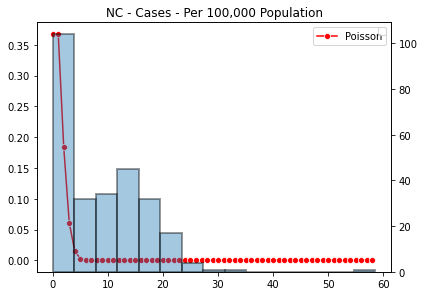

In [10]:
norm_1_nc = get_weekly_total_from_team_df(confirmed_usa,state="NC", normByPop=True,popScaler=100000)

poisson_intervals = np.arange(norm_1_nc["total"].max())   

#Create sub plots for plot histogram and poisson
fig, ax1 = plt.subplots()

#plot the Poisson distribution line
ax1 = seaborn.lineplot(poisson_intervals, scipy.stats.poisson.pmf(poisson_intervals, mu=1), color="red", label="Poisson", marker="o")
ax2 = ax1.twinx()

#Plot the covid data
seaborn.distplot(norm_1_nc["total"], kde=False, bins=15, ax = ax2, hist_kws=dict(edgecolor="k", linewidth=2))

plt.legend()
fig.tight_layout()

plt.title("{} - {} - Per {:,} Population".format("NC", "Cases", 100000))
plt.show()

## End of Part 1

## Part 2
### Model a poission distribution of COVID-19 cases and deaths of a state and compare to other 5 states
- MI
- GA
- TN 
- WA
- NJ

### Model Confirmed Cases & Deaths with Poisson Distribution for North Carolina Per 10,000,000 Populations

In [11]:
#NC - Confirmed Cases
model_datawith_poisson(confirmed_usa, "NC",county_name=None, dataLabel="Confirmed Cases",normFactor=10000000)

No handles with labels found to put in legend.


In [12]:
#NC - Deaths
model_datawith_poisson(deaths_usa, "NC", county_name=None, dataLabel="Deaths",normFactor=10000000)

No handles with labels found to put in legend.


### Model Confirmed Cases & Deaths with Poisson Distribution for Michigan Per 10,000,000 Populations

In [13]:
#MI confirmed
model_datawith_poisson(confirmed_usa, "MI",county_name=None, dataLabel="Confirmed Cases",normFactor=10000000)

No handles with labels found to put in legend.


In [14]:
#MI Deaths
model_datawith_poisson(deaths_usa, "MI", county_name=None, dataLabel="Deaths",normFactor=10000000)

No handles with labels found to put in legend.


### Model Confirmed Cases & Deaths with Poisson Distribution for Georgia Per 10,000,000 Populations

No handles with labels found to put in legend.


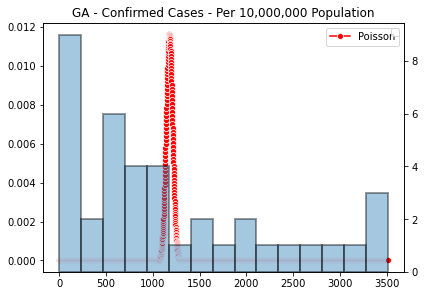

In [15]:
# GA Confirmed
model_datawith_poisson(confirmed_usa, "GA",county_name=None, dataLabel="Confirmed Cases",normFactor=10000000)

No handles with labels found to put in legend.


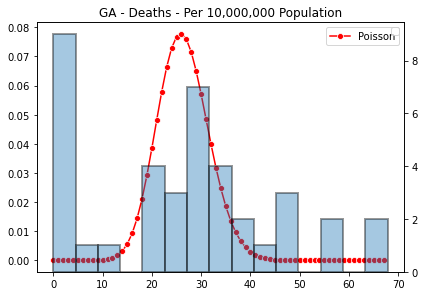

In [16]:
# GA Deaths
model_datawith_poisson(deaths_usa, "GA", county_name=None, dataLabel="Deaths",normFactor=10000000)

### Model Confirmed Cases & Deaths with Poisson Distribution for Tennessee Per 10,000,000 Populations

No handles with labels found to put in legend.


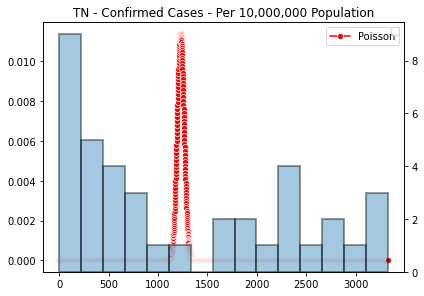

In [17]:
#TN Confirmed Cases
model_datawith_poisson(confirmed_usa, "TN",county_name=None, dataLabel="Confirmed Cases",normFactor=10000000)

In [18]:
#TN Deaths
model_datawith_poisson(deaths_usa, "TN", county_name=None, dataLabel="Deaths",normFactor=10000000)

No handles with labels found to put in legend.


### Model Confirmed Cases & Deaths with Poisson Distribution for Washington Per 10,000,000 Populations

In [19]:
# WA - Confirmed Case
model_datawith_poisson(confirmed_usa, "WA",county_name=None, dataLabel="Confirmed Cases",normFactor=10000000)

No handles with labels found to put in legend.


No handles with labels found to put in legend.


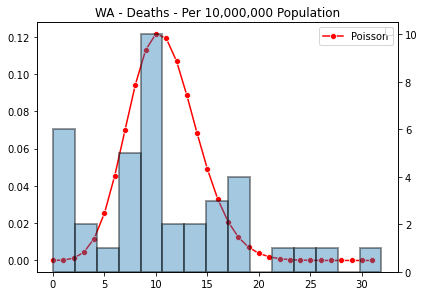

In [20]:
#WA Deaths
model_datawith_poisson(deaths_usa, "WA", county_name=None, dataLabel="Deaths",normFactor=10000000)

### Model Confirmed Cases & Deaths with Poisson Distribution for New Jersey Per 10,000,000 Populations

No handles with labels found to put in legend.


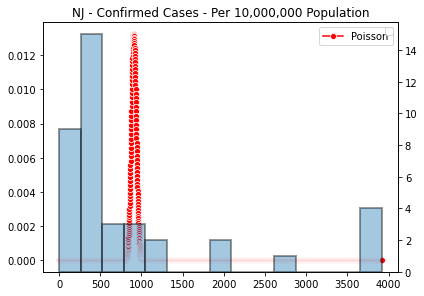

In [21]:
#NJ Confirmed Cases
model_datawith_poisson(confirmed_usa, "NJ",county_name=None, dataLabel="Confirmed Cases",normFactor=10000000)

In [22]:
#NJ Deaths
model_datawith_poisson(deaths_usa, "NJ", county_name=None, dataLabel="Deaths",normFactor=10000000)

No handles with labels found to put in legend.


## End of Part 2

## Part 3 
### Model poission distributions for North Carolina counties COVID-19 in cases and deaths. For example, Number of new cases and deaths per 100,000 populations.

No handles with labels found to put in legend.


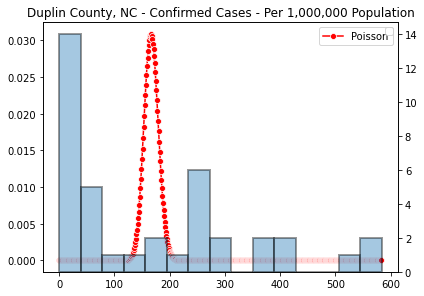

In [23]:
#Dupin County - Confirmed Cases
model_datawith_poisson(confirmed_usa, "NC",county_name="Duplin County", dataLabel="Confirmed Cases",normFactor=1000000)

No handles with labels found to put in legend.


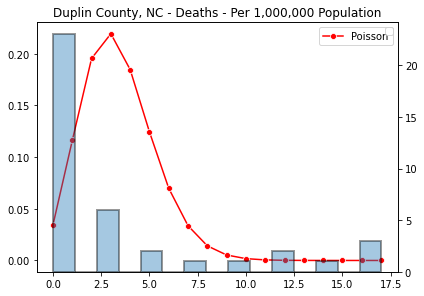

In [24]:
#Dupin County - Deaths
model_datawith_poisson(deaths_usa, "NC", county_name="Duplin County", dataLabel="Deaths",normFactor=1000000)

No handles with labels found to put in legend.


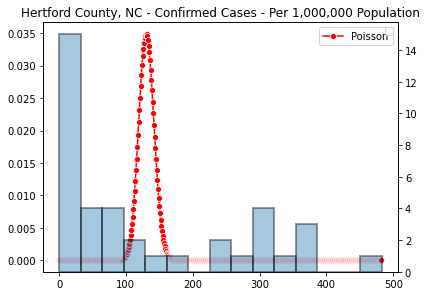

In [25]:
#Hertford County - Confirmed
model_datawith_poisson(confirmed_usa, "NC",county_name="Hertford County", dataLabel="Confirmed Cases",normFactor=1000000)


No handles with labels found to put in legend.


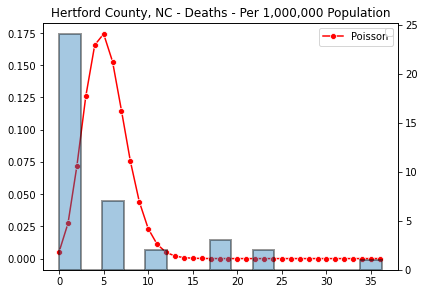

In [26]:
#Hertford County - Deaths
model_datawith_poisson(deaths_usa, "NC", county_name="Hertford County", dataLabel="Deaths",normFactor=1000000)

No handles with labels found to put in legend.


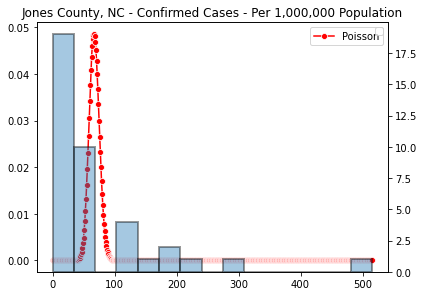

In [27]:
#Jones County
model_datawith_poisson(confirmed_usa, "NC",county_name="Jones County", dataLabel="Confirmed Cases",normFactor=1000000)

No handles with labels found to put in legend.


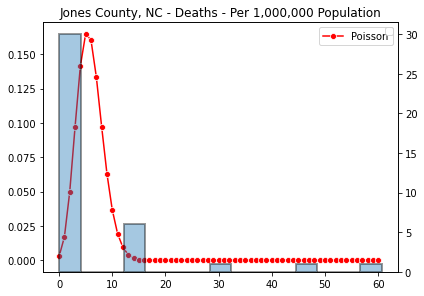

In [28]:
#Jones County - deaths 
model_datawith_poisson(deaths_usa, "NC", county_name="Jones County", dataLabel="Deaths",normFactor=1000000)

In [29]:
#Robeson County - confirmed cases
model_datawith_poisson(confirmed_usa, "NC",county_name="Robeson County", dataLabel="Confirmed Cases",normFactor=1000000)

No handles with labels found to put in legend.


No handles with labels found to put in legend.


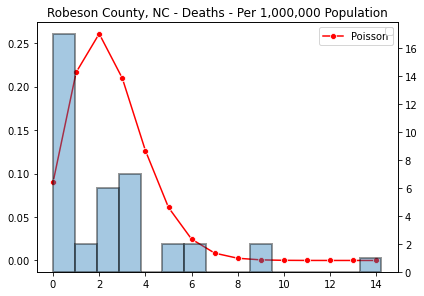

In [30]:
#Robeson County - deaths
model_datawith_poisson(deaths_usa, "NC", county_name="Robeson County", dataLabel="Deaths",normFactor=1000000)

No handles with labels found to put in legend.


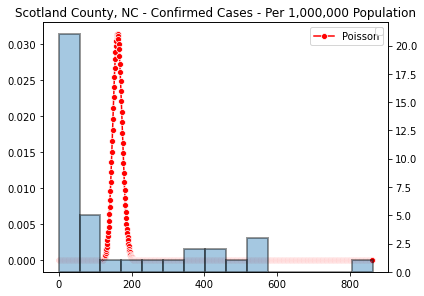

In [31]:
#Scotland County - confirmed cases
model_datawith_poisson(confirmed_usa, "NC",county_name="Scotland County", dataLabel="Confirmed Cases",normFactor=1000000)

No handles with labels found to put in legend.


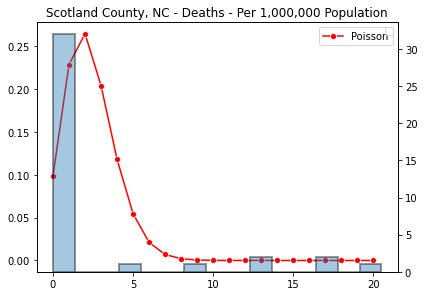

In [32]:
#Scotland County - Deaths cases
model_datawith_poisson(deaths_usa, "NC", county_name="Scotland County", dataLabel="Deaths",normFactor=1000000)

## End of Part 3

## Part 4 
### Perform corelation between Enrichment data valiables and COVID-19 cases to observe any patterns
### *Within North Carolina Counties

### Compute values for confirmed cases & employment

In [33]:
#Get all North Carolina County Confirmed Cases and Normalize by popluation
nc_data_counties_confirmed = get_county_data_totals(confirmed_usa, "NC", normByPop=True, popScaler=100000.00)

#Rename columns
nc_data_counties_confirmed.rename(columns={"Total":"Confirmed"}, inplace=True)

#Get all North Carolina County Employment Total & Nor
nc_emp_data = get_recent_months_employment_dataframe(team_super_df_With_Employment,state="NC", normByPop=True, popScaler=100000.00)
nc_emp_data_colForMerge = ["County Name", nc_emp_data.columns[-1]]

#Merge the county cases and employment
nc_data_counties_confirmed_emp_merged = pd.merge(nc_data_counties_confirmed, nc_emp_data[nc_emp_data_colForMerge], left_on="County Name", right_on="County Name")

#rename needed columns for the merge dataframes
nc_data_counties_confirmed_emp_merged.columns = ["County Name", "population", "Confirmed", "employment"]

print(nc_data_counties_confirmed_emp_merged.head())

         County Name  population  Confirmed  employment
0      Duplin County       58741     4549.0     32267.0
1    Scotland County       34823     4414.0     33693.0
2     Robeson County      130625     4301.0     30451.0
3  Montgomery County       27173     4203.0     33975.0
4     Sampson County       63531     4007.0     28444.0


### Plot the possible correlation between confirmed cases & Employment Total

In [34]:
#Complute the a line of regression for the confirmed and employment data
line_m, line_b, r_value, p_value, std_err = scipy.stats.linregress(nc_data_counties_confirmed_emp_merged["Confirmed"],  nc_data_counties_confirmed_emp_merged["employment"])

#Plot the both confirmed-x and employment total-y and a best fit line.
plt.figure(figsize=(10,5))
plt.scatter(nc_data_counties_confirmed_emp_merged["Confirmed"], nc_data_counties_confirmed_emp_merged["employment"] )
plt.plot(nc_data_counties_confirmed_emp_merged["Confirmed"], line_m * nc_data_counties_confirmed_emp_merged["Confirmed"] + line_b, label="Line of Best Fit", c="darkred")
plt.xlabel("COVID Total Cases")
plt.ylabel("Total Employment")
plt.title("COVID Cases To Employment Relation")
plt.show()

In [35]:
#Print Stats
print("Stats:")
print("R:{0}".format(r_value))
print("P:{0}".format(p_value))
print("STD Error:{0}".format(std_err))

Stats:
R:0.14035694861613293
P:0.16367169852680188
STD Error:1.3712446770186868


## End of Part 4

## Part 5
### Formulate hypothesis between Enrichment data and number of cases to be compared against states. Choose 3 different variables to compare against.

## Based on the data above, it can be said that there seems to be a correlation between Employment totals and the number of cases. It is possible that the different types of employment, government, manufacturing, and service jobs might have a higher correlation.



## Hypothesis:
## Does a larger employment of  government, manufacturing, or service jobs in an area cause more confirmed cases of covid?


## End of Part 5